# Introdução

O objetivo deste trabalho é gerar um classificador knn para a base de dados [adult](https://archive.ics.uci.edu/dataset/2/adult). Esta base de dados contém os dados do censo americado de 1998 e 
Para isto vamos ler os dados, tratar inconsistências, definir atributos mais relevantes, definir os hiperparâmetros com validação cruzada e avaliar o desempenho do classificador

## Importando bibliotecas e lendo base de dados

In [2]:
import os; import numpy as np; import pandas as pd; import seaborn as sns; import matplotlib.pyplot as plt; from sklearn.neighbors import KNeighborsClassifier; from sklearn import preprocessing; import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #disable warnings to clean notebook
prop_cycle = plt.rcParams['axes.prop_cycle']; colors = prop_cycle.by_key()['color']; CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
DATA_DIR = os.path.join(CURRENT_DIR, 'data'); TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data'); TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test'); from collections import OrderedDict
data_types = OrderedDict([
    ("age", "int"), ("workclass", "category"), ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"), ("education_num", "int"), ("marital_status", "category"),
    ("occupation", "category"),("relationship", "category"),("race", "category"),
    ("sex", "category"),("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),("hours_per_week", "int"),
    ("native_country", "category"),("income_class", "category"),
])
target_column = "income_class"
def read_dataset(path):
    data = pd.read_csv(
        path,
        names=data_types,
        index_col=None,
        dtype=data_types,
        comment='|',  
        skipinitialspace=True
    )
    return data
train_data = read_dataset(TRAIN_DATA_FILE)
test_data = read_dataset(TEST_DATA_FILE)
data = pd.concat([test_data, train_data])
(data.describe(include='all'));


# Pré-processamento
## Remoção de inconsistências
Vemos de cara que algumas classes estão com valores inconsistencias. Por exemplo a classe alvo 'income_class' tem 4 valores quando na verdade deveriam ter apenas 2.


In [3]:
data.income_class.value_counts();

Observando o value_counts vemos que isto se deve a um '.' adicional em uma das categorias.
Deve ser limpado:

In [4]:
data['income_class'] = data.income_class.str.rstrip('.').astype('category');

Também notamos que algumas categorias numéricas tem valores '9' de forma muito frequente o que pode indicar um placeholder para valores faltantes nestas categorias.
Observando a frequência dos 5 valores mais comuns de 'capital_gain' e 'hours_per_week'

In [5]:
import heapq
hours_per_week_counts = data.hours_per_week.value_counts()
data.hours_per_week.value_counts()[hours_per_week_counts.index.isin(heapq.nlargest(3, data.hours_per_week.unique()))]

hours_per_week
99    137
98     14
97      2
Name: count, dtype: int64

In [6]:
import heapq
capital_gain_counts = data.capital_gain.value_counts()
data.capital_gain.value_counts()[capital_gain_counts.index.isin(heapq.nlargest(3, data.capital_gain.unique()))]

capital_gain
99999.0    244
34095.0      6
41310.0      3
Name: count, dtype: int64

Como esperado vemos que estes valores estão muito mais frequentes que suas redondezas, indicando que devem ser removidos.
Para isto vamos substituí-los pela média destas colunas já excluindo estes valores.

In [7]:
capital_mean = np.mean(data.capital_gain[data.capital_gain != 99999])
data['capital_gain'] = data['capital_gain'].replace(99999, capital_mean)
hours_per_week_mean = np.mean(data.hours_per_week[data.hours_per_week != 99])
data['hours_per_week'] = data['hours_per_week'].replace(99, hours_per_week_mean)

## Dados faltantes
Observando os dados vemos que as colunas 'workclass', 'occupation' e 'native_country' tem dados faltantes indicados por '?'. Nestas categorias vamos substituir os valores faltantes pelos mais frequentes nestas classes.

## Avaliação de Classes Correlacionadas

Observando as colunas é imediato que algumas classes devem ter grande correlação entre si. Por exemplo: é de se esperar uma correlação grande entre 'relationship' e 'marital_status', 'education' e 'education_num'.
Para garantir que não estamos introduzindo nenhum viés adicional a base de dados vamos avaliar a correlação entre estas colunas.
Para avaliar a correlação entre duas categorias vamos utilizar a métrica 'Cramers V'.

In [8]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association. uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    n = n.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

confusion_matrix = pd.crosstab(data['marital_status'], data['relationship'])
cramers_v(confusion_matrix=confusion_matrix)

np.float64(0.4880589431633566)

In [9]:
confusion_matrix = pd.crosstab(data['workclass'], data['occupation'])
cramers_v(confusion_matrix)

np.float64(0.3997244048209072)

Para avaliar a correlação entre 'education' e 'education_num' vamos utilizar a correlação biserial e utilizar uma serialização por LabelEncoder para  'education' apenas para verificar a correlação.

In [10]:
le = preprocessing.LabelEncoder()
education = le.fit_transform(data.education)
stats.pointbiserialr(education, data.education_num)

SignificanceResult(statistic=np.float64(0.3596676843392162), pvalue=np.float64(0.0))

Desta forma, vemos que há uma alta covariância entre estas colunas.

Para simplificar o modelo vamos escolher as colunas education_num (por já ser numérica e carregar a informação de "mais anos estudados"), relationship  e occupation.

## Classes com elementos superrepresentados

Vemos que na coluna 'native_country' 90% dos respondentes tem nacionalidade 'United-States' e além disso, temos 42 categorias diferentes para esta coluna.
Por conta disso vamos trocar essa classe por: native-american com 1 indicando que é americano, 0 indicando que não.

In [11]:
data['native_country'] = data['native_country'].astype('category'); mode = data['native_country'].cat.codes.mode();  usa_map = lambda a : True if a == mode[0] else False;
native_usa = data['native_country'].cat.codes.map(usa_map); data = data.drop('native_country', axis=1)
native_usa_df = pd.DataFrame(data={'native_usa': native_usa})
data = pd.concat([data, native_usa_df], axis=1)

Com isto podemos criar uma função para limpar todos os dados e mapear os valores inteiros entre 0 a 1 dividindo pelo máximo da coluna e utilizar HotEncoding para os valores categócios

In [12]:
def clean_dataset(data):
    data = data.drop('final_weight', axis=1); data = data.drop('workclass', axis=1); data = data.drop('education', axis=1); data = data.drop('relationship', axis=1) #drops
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    capital_mean = np.mean(data.capital_gain[data.capital_gain != 99999])
    data['capital_gain'] = data['capital_gain'].replace(99999, capital_mean)
    hours_per_week_mean = np.mean(data.hours_per_week[data.hours_per_week != 99])
    data['hours_per_week'] = data['hours_per_week'].replace(99, hours_per_week_mean)
    data['occupation'] = data['occupation'].replace('?', 'Prof-specialty')
    data['native_country'] = data['native_country'].replace('?', 'United-States')
    data['native_country'] = data['native_country'].astype('category')
    mode = data['native_country'].cat.codes.mode()
    usa_map = lambda a : True if a == mode[0] else False
    native_usa = data['native_country'].cat.codes.map(usa_map)
    data = data.drop('native_country', axis=1)
    data = pd.concat([data, native_usa], axis=1)
    data['marital_status'] = data['marital_status'].replace('?', 'Married-civ-spouse')
    data['age'] = data['age']/90
    data['education_num'] = data['education_num']/16
    data['capital_gain'] = data['capital_gain']/41310.0
    data['capital_loss'] = data['capital_loss']/4356.0
    data['hours_per_week'] = data['hours_per_week']/98
    marital_oh = pd.get_dummies(data['marital_status'])
    data = data.drop('marital_status', axis=1)
    data = pd.concat([data, marital_oh], axis=1)
    occupation_oh = pd.get_dummies(data['occupation'])
    data = data.drop('occupation', axis=1)
    data = pd.concat([data, occupation_oh], axis=1)
    race_oh = pd.get_dummies(data['race'])
    data = data.drop('race', axis=1)
    data = pd.concat([data, race_oh], axis=1)
    sex_oh = pd.get_dummies(data['sex'])
    data = data.drop('sex',axis=1)
    data = pd.concat([data, sex_oh], axis=1)
    data = data.drop_duplicates()
    y = data['income_class']
    data = data.drop('income_class', axis=1)
    return data, y


In [13]:
clean_test, clean_output = clean_dataset(test_data)
clean_train, train_output = clean_dataset(train_data)

## Construção do kNN
Para construir o classificador kNN precisamos definir o hiperparametro n.
Para isso vamos utilizar o método k-fold cross validation. A cada etapa iremos avaliar a média dos scores do classificador em cada k-fold.


In [14]:
from sklearn.model_selection import KFold
n = 1
n_folds = 5
kf = KFold(n_splits=n_folds)
mean_acc = []
while n < 25:
    mse = 0
    kf.get_n_splits(clean_train.values)
    for i, (train_index, test_index) in enumerate(kf.split(clean_train.values)):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(clean_train.values[train_index], train_output.values[train_index])
        mse = mse + knn.score(clean_train.values[test_index],
                               train_output.values[test_index])
    mse = mse / n_folds
    mean_acc.append((n, mse))
    n = n + 1

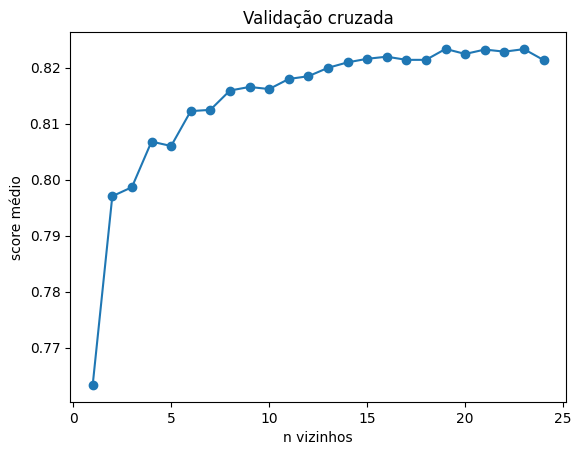

In [15]:
n, acc = zip(*mean_acc)
plt.plot(n, acc, marker='o')
plt.xlabel('n vizinhos')
plt.ylabel('score médio')
plt.title("Validação cruzada")
plt.rcParams['figure.figsize'] = [3, 2]
plt.show()

Vemos que após 10 vizinhos a melhora da qualidade do score começa a diminuir se mantendo praticamente constante após 15 vizinhos.
Estava variação errática pode começar a indicar um "overfitting" ao aumentar muito o número de vizinhos buscados.
Desta forma iremos adotar n = 15 vizinhos para nosso classificador

# Análise do classificador construído
Para isto vamos apresentar a acurácia, precisão e revocação para o classificador com n = 15 vizinhos.
Estas três métricas podem ser extraídas da tabela de confusão do modelo.

In [16]:
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(clean_train.values, train_output.values)
predition = knn.predict(clean_test.values)
cm = confusion_matrix(clean_output, predition)

In [17]:
acc = (cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1]+cm[1][0] + cm[1][1]) 
precision = cm[0][0]/(cm[0][1] + cm[0][0])
recall = cm[0][0]/(cm[0][0] + cm[1][0])
print(f'Acurácia= {acc} Precisão {precision} Revocação {recall}')

Acurácia= 0.8273366274618972 Precisão 0.9130915116921378 Revocação 0.8658227848101265


# Conclusão
Utilizando o tratamento dos dados sugeridos e escolhendo um classificador com 15 vizinhos mais próximos obtivemos uma acurácia de 0.827, precisão de 0.91 e revocação de 0.86.
Desta forma mostramos que o filtragem dos dados que realizamos, tanto o tratamento de inconsistências quanto a codificação resultou num classificador bom (Acurácia > 80%) mesmo utilizando um modelo simples (knn).